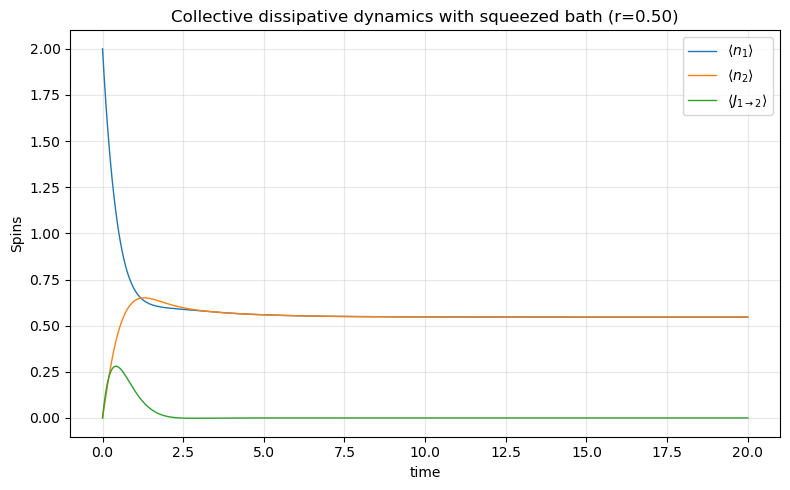

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

Gamma = 1.0
Eta = 0.8
r = 0.5
phi = 0.5
Nq = 2
N = 0.2
omega_1, omega_2 = 1.0, 1.0
omega = [omega_1, omega_2]
Omega_12 = Omega_21 = 0.66
Omega = [[0.0, Omega_12],
         [Omega_21, 0.0]]

N_tilde = N * (np.sinh(r)**2 + np.cosh(r)**2) + np.sinh(r)**2
M = - 0.5 * np.sinh(2*r) * np.exp(1j*phi) * (2*N + 1)

sm = [qt.tensor([qt.destroy(2) if m==n else qt.qeye(2) for m in range(Nq)]) for n in range(Nq)]
sp = [s.dag() for s in sm]
I_sys = qt.tensor([qt.qeye(2) for _ in range(Nq)])
sz = [2*sp[i]*sm[i] - I_sys for i in range(Nq)]
n1 = sp[0]*sm[0]
n2 = sp[1]*sm[1]

H = qt.qzero([Nq, Nq])

for i in range(Nq):
    H += omega[i] * sz[i]
    for j in range(Nq):
        if i != j:
            H += Omega[i][j] * sp[i] * sm[j]

J_op = 1j*Omega_12*(sp[0]*sm[1] - sp[1]*sm[0])

C = np.array([[1.0, Eta],
              [Eta, 1.0]], dtype=complex)

def D_super(A, B):
    return qt.spre(A) * qt.spost(B) - 0.5*qt.spre(B*A) - 0.5*qt.spost(B*A)

L = -1j*(qt.spre(H) - qt.spost(H))

for i in range(Nq):
    for j in range(Nq):
        Gamma_ij = Gamma*C[i,j]
        L += Gamma_ij*(N_tilde +1) * D_super(sm[i], sp[j])
        L += Gamma_ij * N_tilde * D_super(sp[i], sm[j])
        if M != 0:
            L += -Gamma_ij*M * D_super(sp[i], sp[j])
            L += -Gamma_ij*np.conj(M) * D_super(sm[i], sm[j])

rho0 = qt.ket2dm(qt.tensor(qt.basis(2,1), qt.basis(2,0)))

tlist = np.linspace(0, 20, 400)
result = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[n1, n2, J_op])

n1_t  = np.real(result.expect[0])
n2_t  = np.real(result.expect[1])
J_t   = np.real(result.expect[2])

plt.figure(figsize=(8,5))
plt.plot(tlist, 2*n1_t, label=r'$\langle n_1\rangle$', lw=1.0)
plt.plot(tlist, 2*n2_t, label=r'$\langle n_2\rangle$', lw=1.0)
plt.plot(tlist, 2*J_t,  label=r'$\langle J_{1\to2}\rangle$', lw=1.0)
plt.xlabel("time")
plt.ylabel("Spins")
plt.title(f"Collective dissipative dynamics with squeezed bath (r={r:.2f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

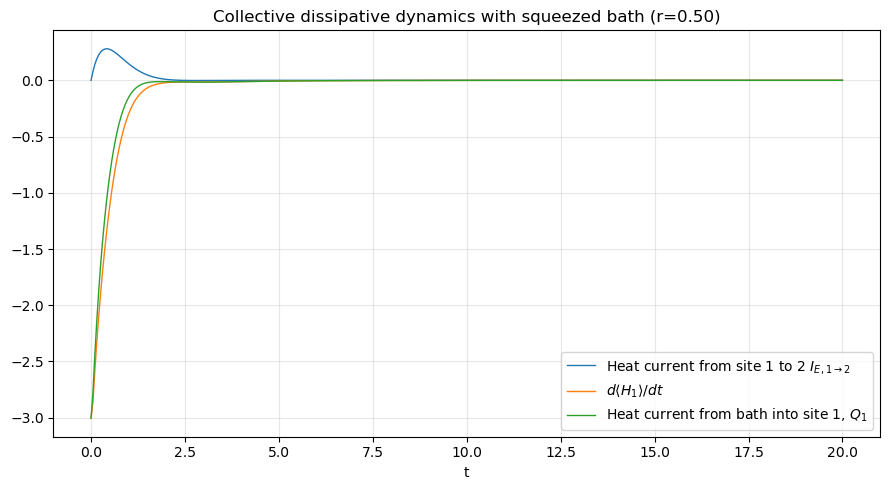

In [11]:
H1 = omega[0] * sz[0]
H2 = omega[1] * sz[1]

result = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[n1, n2, J_op, H1])

n1_t  = np.real(result.expect[0])
n2_t  = np.real(result.expect[1])
J_t   = np.real(result.expect[2])
H1_t  = np.real(result.expect[3])

I_E_t = 2.0 * omega[0] * J_t

dH1_dt = np.gradient(H1_t, tlist)

Q1_t = dH1_dt + I_E_t

plt.figure(figsize=(9,5))
plt.plot(tlist, I_E_t, label='Heat current from site 1 to 2 $I_{E,1\\to2}$', lw=1.0)
plt.plot(tlist, dH1_dt, label=r'$d\langle H_1\rangle/dt$', lw=1.0)
plt.plot(tlist, Q1_t, label='Heat current from bath into site 1, $Q_1$', lw=1.0)
plt.title(f"Collective dissipative dynamics with squeezed bath (r={r:.2f})")
plt.legend()
plt.xlabel('t')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Calculating current using FCS

$$
\mathcal{J} \rho := -\iota \partial_\chi \mathcal{L}_\chi \rho |_{\chi=0}
$$

where $\chi$ is the counting field.

The (particle) current will be, $J = \textbf{Tr} (\mathcal{J} \rho)$

If we take $\mathcal{L} \rho = -\iota [H, \rho] + \gamma (\tilde{N} + 1) \mathcal{D}[\sigma_-] \rho + \gamma \tilde{N} \mathcal{D}[\sigma_+] \rho$

Then $J$ will be,

$$
J = \textbf{Tr}(\mathcal{J} \rho) = \gamma (\tilde{N} + 1) \langle \sigma_+ \sigma_- \rangle_\rho + \gamma \tilde{N} \langle \sigma_- \sigma_+ \rangle_\rho
$$

In this case our current will be,


$$
J = \textbf{Tr} (\mathcal{J} \rho) = \sum_{i,j=1}^2 
\Gamma_{ij} \Big[ (\tilde{N}+1)\, \langle S_i^+ S_j^- \rangle_\rho
+ \tilde{N}\, \langle S_i^- S_j^+ \rangle_\rho
 - \tilde{M}\, \langle S_i^+ S_j^+ \rangle_\rho
 - \tilde{M^{*}}\, \langle S_i^- S_j^- \rangle_\rho \Big].
$$


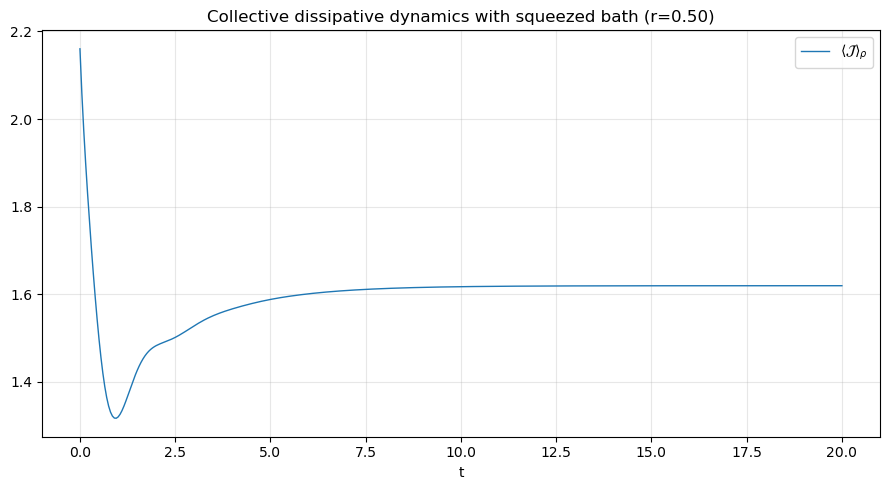

In [12]:
J = qt.qzero([Nq, Nq])

for i in range(Nq):
    for j in range(Nq):
        Gamma_ij = Gamma*C[i,j]
        J += Gamma_ij * (N_tilde + 1) * sp[i]*sm[j] + Gamma_ij * N_tilde * sm[i]*sp[j] - Gamma_ij * M * sp[i]*sp[j] - Gamma_ij * np.conj(M) * sm[i]*sm[j]

result = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[J])

plt.figure(figsize=(9,5))
plt.plot(tlist, result.expect[0], label=r'$\langle \mathcal{J} \rangle_\rho$', lw=1.0)
plt.title(f"Collective dissipative dynamics with squeezed bath (r={r:.2f})")
plt.legend()
plt.xlabel('t')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

For $\theta = 0^\circ$ (c=1) = 1.00 as k_0 r_ij -> 0 the value of Omega_ij = -1507.48
For $\theta = 54.74^\circ$ (c^2=1/3) = 0.58 as k_0 r_ij -> 0 the value of Omega_ij = -4.98
For $\theta = 90^\circ$ (c=0) = 0.00 as k_0 r_ij -> 0 the value of Omega_ij = 746.28


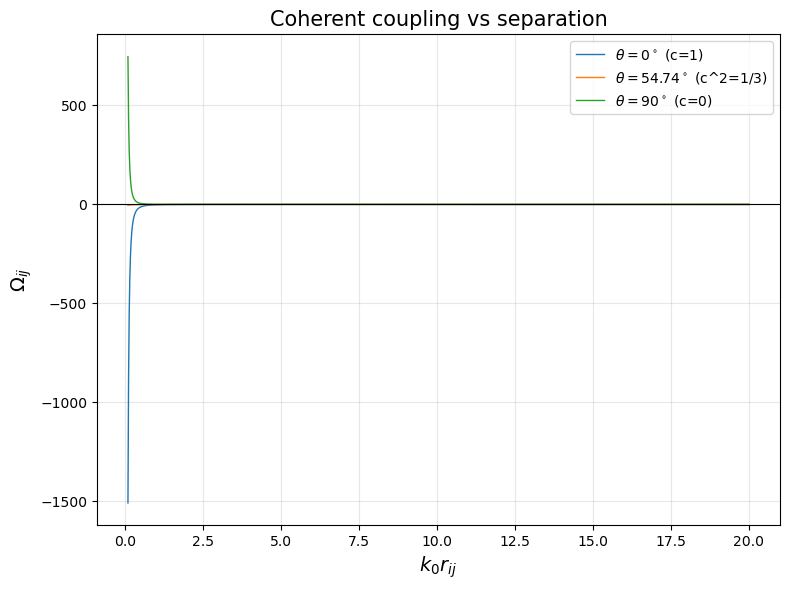

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def Omega(x, c):
    """
    Coherent dipole-dipole coupling Omega_ij (up to overall prefactor).
    
    Parameters:
    x : array of k0 * r values
    c : cos(theta) = hat(l) · hat(r)
    """
    return (3/4) * ((1 - 3*c**2) * (np.cos(x)/x**3 + np.sin(x)/x**2)
            - (1 - c**2) * (np.cos(x)/x))

# range of k0 * r
x = np.linspace(0.1, 20, 2000)  # start at 0.1 to avoid division by 0

# orientation cases
angles = {
    r"$\theta = 0^\circ$ (c=1)": 1.0,         # dipole along r
    r"$\theta = 54.74^\circ$ (c^2=1/3)": 1/np.sqrt(3),
    r"$\theta = 90^\circ$ (c=0)": 0.0         # dipole perpendicular to r
}

plt.figure(figsize=(8,6))
for label, c in angles.items():
    plt.plot(x, Omega(x, c), label=label, lw=1.0)
    print("For %s = %0.2f as k_0 r_ij -> 0 the value of Omega_ij = %0.2f" %(label, c, Omega(x, c)[0]))

plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel(r"$k_0 r_{ij}$", fontsize=14)
plt.ylabel(r"$\Omega_{ij}$", fontsize=14)
plt.title("Coherent coupling vs separation", fontsize=15)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()